# Projet 4: Anticipez les besoins en consommation de bâtiments: Modélisation

In [2]:
from urllib import request
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot, transforms
import seaborn as sns
import numpy as np
import IPython.display

# preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
 
#Feature selecction
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE

#Ensemble de transformation: Pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector


from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

#Models 
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor


import warnings
warnings.filterwarnings('ignore')

### lecture de données 

In [3]:
filepath_2016_cleaned = 'C:/Users/Mohamed/Desktop/formation_data_Scientist/projet_4/Donnees/df_cleaned_2016'
filepath_data_cleaned  = 'C:/Users/Mohamed/Desktop/formation_data_Scientist/projet_4/Donnees/df_cleaned_data'

In [4]:
df_2016 = pd.read_csv(filepath_2016_cleaned)
data = pd.read_csv(filepath_data_cleaned)

In [5]:
df_2016.drop('diff_energy', axis = 1, inplace = True)

In [94]:
y = df_2016['SiteEnergyUseWN(kBtu)']
X = df_2016.drop(['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'], axis=1)

In [95]:

X_train, X_test, y_train, y_test =  train_test_split(X, y,  
                                         test_size = 0.2, 
                                         random_state = 0)

In [8]:
df_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1546 entries, 0 to 1545
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   BuildingType                     1546 non-null   object 
 1   PrimaryPropertyType              1546 non-null   object 
 2   CouncilDistrictCode              1546 non-null   float64
 3   Neighborhood                     1546 non-null   object 
 4   Latitude                         1546 non-null   float64
 5   Longitude                        1546 non-null   float64
 6   YearBuilt                        1546 non-null   float64
 7   NumberofBuildings                1546 non-null   float64
 8   NumberofFloors                   1546 non-null   float64
 9   PropertyGFATotal                 1546 non-null   int64  
 10  LargestPropertyUseType           1546 non-null   object 
 11  LargestPropertyUseTypeGFA        1546 non-null   float64
 12  SecondLargestPropert

In [9]:
data.drop('diff_energy', axis = 1, inplace = True)

In [10]:
df_2016['LargestPropertyUseType'].unique()

array(['Other', 'Office', 'Warehouse'], dtype=object)

## 1: Préprocessing et selection de variables: méthode 1

### 1.1: Préparation du vecteur et matrice: Normalisation & One Hot Encoder

In [322]:
def preprocessor(df, target):
    
    y = df[target]
    X = df.drop(['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'], axis=1)
    
    categorical_columns = X.select_dtypes(['category','object']).columns
    numerical_columns = X.select_dtypes(['int64','float64']).columns

    StadScaler = StandardScaler()
    X[numerical_columns] = StadScaler.fit_transform(X[numerical_columns])
    ohe = OneHotEncoder(sparse=False)
    ohe.fit_transform(X[categorical_columns])

    X = pd.merge(X[numerical_columns], 
          pd.DataFrame(columns = ohe.get_feature_names().tolist(),
              data = ohe.fit_transform(X[categorical_columns])),
        left_index = True, right_index = True)
    
    return X

X = preprocessor(df = df_2016, target= 'SiteEnergyUseWN(kBtu)')
X_train, X_test, y_train, y_test =  train_test_split(X, y,  
                                         test_size = 0.2, 
                                         random_state = 0)   

In [323]:
X 

,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,...,x3_Other,x3_Warehouse,x4_Nothing,x4_Office,x4_Other,x4_Parking,x4_Warehouse,x5_Nothing,x5_Other,x5_Warehouse
0,1.180026,-0.091048,-0.193096,-1.052677,-0.070176,1.138638,-0.107657,-0.040088,-0.377743,-0.181019,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.180026,-0.070395,-0.018386,1.047754,-0.070176,0.991194,-0.058268,-0.056054,-0.090114,0.067056,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.180026,-0.054213,-0.197830,0.225846,-0.070176,5.414516,2.724331,2.302070,-0.377743,-0.181019,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.180026,-0.050168,-0.135003,-1.083118,-0.070176,0.843750,-0.196154,-0.135147,-0.377743,-0.181019,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.180026,-0.058046,-0.299816,0.560698,-0.070176,2.023303,0.176777,0.082657,0.920807,-0.181019,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1541,-1.558508,-1.614064,-1.760328,0.621580,-0.070176,-0.483247,-0.336693,-0.286109,-0.377743,-0.181019,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1542,-1.102086,-0.430656,0.459271,1.291282,-0.070176,-0.483247,-0.344073,-0.294036,-0.377743,-0.181019,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1543,1.180026,0.425069,-1.047285,0.378052,-0.070176,-0.483247,-0.353352,-0.323545,-0.271314,-0.181019,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1544,-1.558508,-1.877020,0.395584,0.834667,-0.070176,-0.483247,-0.350271,-0.326988,-0.253614,-0.155041,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### 1.2 : Selection de variables

In [13]:
'''Cette fonction permet d'afficher un barplot du coefficint de chaque variable'''

def show_var_selec(var, coeff):

    liste_coefs_rfe = pd.concat((pd.DataFrame(var, columns = ['Variable']), 
                      pd.DataFrame(coeff, columns = ['Coefficient'])), axis = 1).\
                                            sort_values(by='Coefficient', ascending = False)
    print(liste_coefs_rfe.columns)
    
    #plot de feature name et feature importance
    plt.figure(figsize=(8,8))
    plt.title('RandomForestRegressor - Importance des 20 premières Features')
    sns.barplot(y = liste_coefs_rfe['Variable'].head(20),
            x = liste_coefs_rfe['Coefficient'].head(20))
    plt.show()
    
    return show_var_selec

Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Index(['Variable', 'Coefficient'], dtype='object')


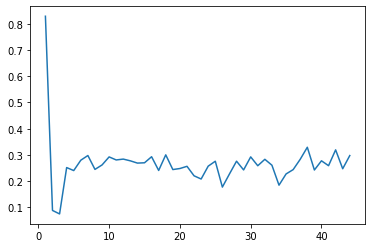

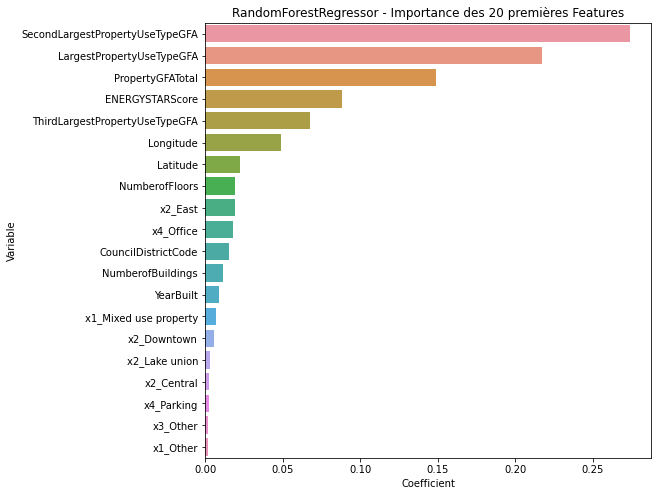

0.9348678155575486


0.8289216500540371

In [14]:
'''Pour sélectionner les variables les plus importantes les deux méthodes RFE et RFECV ont été utilisé. 

'''
def sect_var(cv):
#RFECV: Choix du nombre de variable    
    estimator = RandomForestRegressor()
    
    selector = RFECV(estimator, step=1, cv=cv,  importance_getter='auto')
    selector = selector.fit(X_train, y_train)
    #Variation des features en fonction du scores
    scores = selector.grid_scores_
    average_score = abs(np.mean(scores, axis = 1))
    plt.plot(np.arange(1, len(scores) + 1, 1), average_score)
    ymax = max(average_score)
    max_score = np.where(abs(average_score == ymax))
                         
#RFE: reduction du nombre de variable  
    rfe = RFE(estimator, step=1, verbose=2, n_features_to_select=40)
    rfe = rfe.fit(X_train, y_train)
    rfe_score = rfe.score(X_train, y_train)
    
    # extraire des feature importances et feature name
    feature_coeficient = rfe.estimator_.feature_importances_
    feature_names = rfe.get_feature_names_out()
    
#Appel à la fonction show_var_selec
    show_var_selec(var = feature_names, coeff = feature_coeficient)
    
    mask = rfe.support_
    print(rfe_score)
    mask = rfe.support_
    return ymax
sect_var(cv = 8)

### 1.3 :Choix de variables

In [269]:
def var_to_keep(X):
    var_to_keep = ['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'PropertyGFATotal', 'ENERGYSTARScore',
         'ThirdLargestPropertyUseTypeGFA', 'Longitude', 'NumberofFloors', 'Numberofuilding']

    var_to_drop = []
    for col in X.columns.tolist():
        if col not in var_to_keep:
            var_to_drop.append(col)
    X_reduced = X.drop(var_to_drop, axis = 1)
    
    return X_reduced
X_reduced = var_to_keep(X)

X_train_r, X_test_r, y_train_r, y_test_r =  train_test_split(X_reduced, y,  
                                         test_size = 0.2, 
                                         random_state = 0)    

## 2: Modèlisation

 ### 2.1 : Entrainement de modèles

In [25]:
mymodels = {'SVR': SVR(),'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators = 100, verbose = 0),
           'ElasticNet': ElasticNet(random_state=0),'LinearRegression': LinearRegression(),
            'ExtraTreesRegressor': ExtraTreesRegressor(n_estimators = 100, verbose = 0),
            'RandomForest': RandomForestRegressor()}

In [126]:

#model1 = GridSearchCV(regressor,  param_grid = parameters)

from sklearn.model_selection import GridSearchCV
def data_score( models): 
    
    comparaison_score = pd.DataFrame()  
    
    for name_regressor, regressor in models.items():
        
        #g= GridSearchCV(regressor,  param_grid = parameters)
        
        model = regressor.fit(X_train_r, y_train_r)
        
        comparaison_score.loc[name_regressor, 'R2_train'] =\
                                model.score(X_train_r, y_train_r)
        
        comparaison_score.loc[name_regressor, 'RMSE'] = \
                    math.sqrt(mean_squared_error(y_test_r, model.predict(X_test_r)))
        
        comparaison_score.loc[name_regressor, 'R2_test'] =\
                            r2_score(y_test_r, model.predict(X_test_r))
        
        comparaison_score['RMSE_relative'] =\
                comparaison_score['RMSE'].divide(comparaison_score['RMSE'].max())
        
    return comparaison_score
data_score(models = mymodels)

,R2_train,RMSE,R2_test,RMSE_relative
SVR,-0.054798,1.752948e+07,-0.118126,1.000000
GradientBoostingRegressor,0.962609,1.046286e+07,0.601660,0.596872
ElasticNet,0.433956,1.460134e+07,0.224221,0.832959
LinearRegression,0.542750,1.473141e+07,0.210339,0.840379
ExtraTreesRegressor,1.000000,1.152728e+07,0.516489,0.657594
RandomForest,0.924203,9.288247e+06,0.686079,0.529864


## 2.2: Réglage du meilleur modèle

In [21]:
def show_score(tab, col1, col2, col3, col4):
    fig = plt.figure(figsize = (18, 10))
    gs = fig.add_gridspec(2,2)
    ax = fig.add_subplot(gs[0,0])
    ax1 = fig.add_subplot(gs[0,1])
    ax2 = fig.add_subplot(gs[1,0])
    ax3 = fig.add_subplot(gs[1,1])
    colors = ['tab:orange', 'tab:green', 'tab:blue']
        #ax1 = Histogramme
        #sns.kdeplot(df[col], ax = ax)
    ax.bar(x = tab['Models'], height = tab[col1], color=colors)
#ax.lines[0].set_color('green')
    #ax.set_xlabel('Models')
    ax.set_ylabel(col1)
    #ax.set_title('Comparaison du', col1)
        #ax1: Boite à Maustache
    
    ax1.bar(x = tab['Models'], height = tab[col2],  color=colors)
#ax1.lines[0].set_color('green')
    ax1.set_xlabel('Models')
    ax1.set_ylabel(col2)
    #ax1.set_title('Comparaison du', col2)

    ax2.bar(x = tab['Models'], height = tab[col3], color=colors)
#ax.lines[0].set_color('green')
    ax2.set_xlabel('Models')
    ax2.set_ylabel(col3)
    #ax2.set_title('Comparaison du', col3)

    ax3.bar(x = tab['Models'], height = tab[col4], color=colors)
#ax.lines[0].set_color('green')
    #ax3.set_xlabel('Models')
    ax3.set_ylabel(col4)
    #ax3.set_title('Comparaison du', col4)
    plt.show()

le meillure modèle est:  RandomForestRegressor(n_estimators=1000)


,Models,R2_train,RMSE,R2_test,mean_fit_time
0,GradientBoostingRegressor,0.994328,1.041702e+07,0.605143,0.043739
1,ExtraTreesRegressor,1.000000,1.135799e+07,0.530587,0.007697
2,RandomForest,0.928704,9.611890e+06,0.663822,0.173993


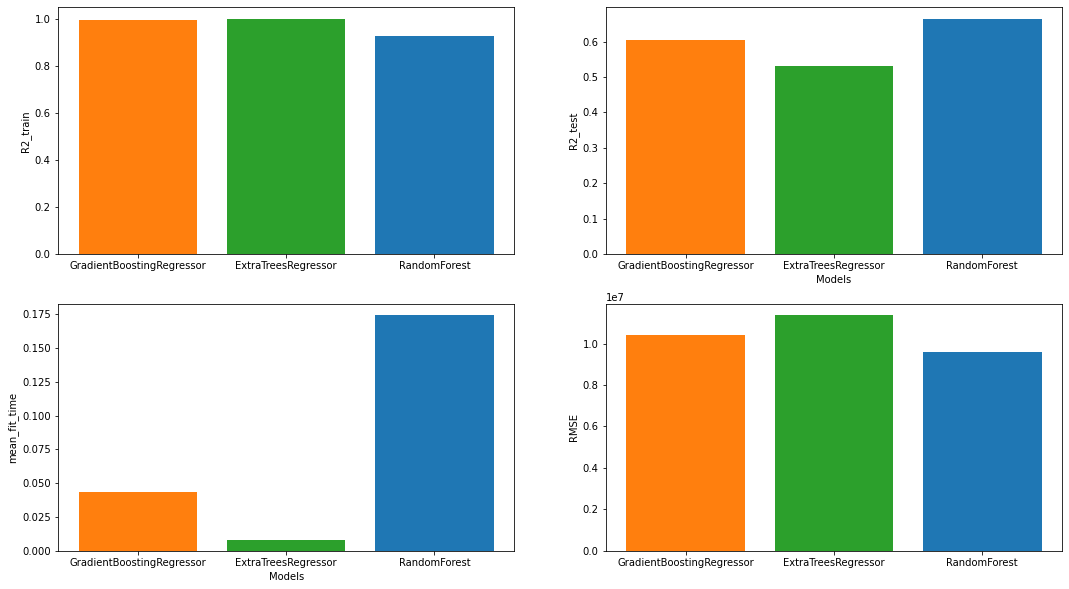

In [75]:
mymodels_2 = {'GradientBoostingRegressor': GradientBoostingRegressor(),
            'ExtraTreesRegressor': ExtraTreesRegressor(),
            'RandomForest': RandomForestRegressor()}

parameters = {'n_estimators': [100, 500, 1000], 'max_features': ['auto']} 

def data_score(models): 
    
    comparaison_score = pd.DataFrame()   
    
    for (name_regressor, regressor) in models.items():
    
            grid = GridSearchCV(regressor,  param_grid = parameters)
        
            model = grid.fit(X_train_r, y_train_r)
            
            best_model_index = model.best_index_
        
            comparaison_score.loc[name_regressor, 'R2_train'] =\
                                model.score(X_train_r, y_train_r)
        
            comparaison_score.loc[name_regressor, 'RMSE'] = \
                    math.sqrt(mean_squared_error(y_test_r, model.predict(X_test_r)))
        
            comparaison_score.loc[name_regressor, 'R2_test'] =\
                            r2_score(y_test_r, model.predict(X_test_r))
            
            comparaison_score.loc[name_regressor, 'mean_fit_time'] = \
                    model.cv_results_['std_fit_time'][best_model_index]
        
    print('le meillure modèle est: ', model.best_estimator_)
            
    return comparaison_score
data_score = data_score(models = mymodels_2)
tab = data_score.reset_index()
tab = tab.rename(columns = {'index': 'Models'})
display(tab)
show_score(tab, col1 = 'R2_train', col2 = 'R2_test', col3 = 'mean_fit_time', col4 ='RMSE')

## 3: Préprocessing et selection de variables: méthode 2

### 3.1: preprocessor: Definitions des pipelines

In [232]:
def preprocessor(df, preprocessor, target, exclude):
    y = df[target]
    X = df.drop(exclude, axis=1)
    #Selection des variables en fonction de leur types
    categ_columns = make_column_selector(dtype_include = ['category','object'])
    numeric_columns = make_column_selector(dtype_include = ['int64','float64'])
    ## Pipeline pour les varibles numériques
    numeric_pipe = make_pipeline(StandardScaler())
    ## Pipeline pour les varibles catégorilles
    catege_pipe =  make_pipeline(OneHotEncoder(sparse=False)) 
    # combiner les colonnes transformés
    preprocessor = make_column_transformer((numeric_pipe, numeric_columns), 
                                     (catege_pipe, categ_columns))
    return preprocessor 

In [265]:
preprocessor_pipe = preprocessor(df_2016, preprocessor, target = ['SiteEnergyUseWN(kBtu)'], 
                            exclude = (['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']))

### 3.2: Selection des variables pertinentes avec RFE et RFECV

Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Index(['Variable', 'Coefficient'], dtype='object')


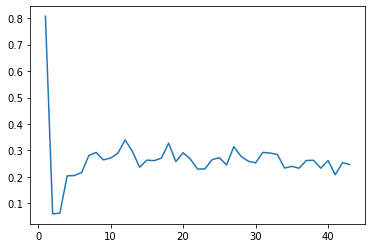

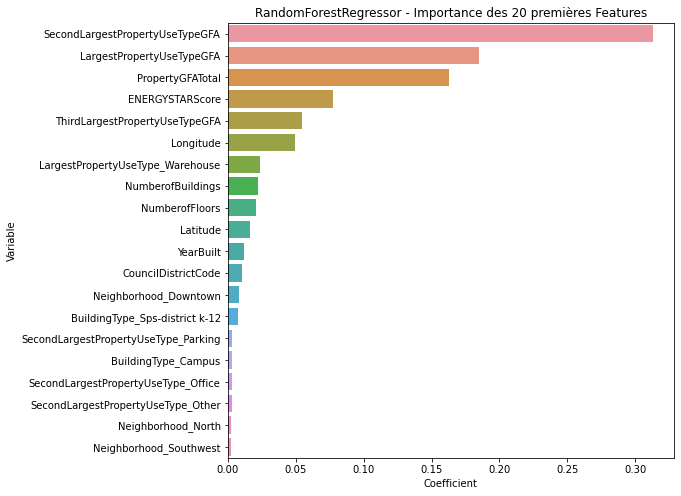

0.9361917247184237


<function __main__.select_var_pipeline(cv)>

In [98]:

def select_var_pipeline(cv):
    estimator = RandomForestRegressor()  
    rfec = RFECV(estimator, step=1, cv=cv,  importance_getter='auto')
    pipe = make_pipeline(preprocessor_pipe,  rfec)
    selector = pipe.fit(X_train, y_train)
    #Variation des features en fonction du scores
    
    scores = rfec.grid_scores_
    average_score = abs(np.mean(scores, axis = 1))
    plt.plot(np.arange(1, len(scores) + 1, 1), average_score)
    ymax = max(average_score)
    max_score = np.where(abs(average_score == ymax))

    
    rfe = RFE(estimator, step=1, verbose=2, n_features_to_select=40)
    #rfe = make_pipeline(rfe)
    pipeline = make_pipeline(preprocessor_pipe, rfe)
    model1 = pipeline.fit(X_train, y_train)

    feature_importances = model1.named_steps['rfe'].estimator_.feature_importances_
    feature1 = model1.named_steps['columntransformer'].transformers_[0][1]\
       .get_feature_names_out()
#feature.append(feature1)
    feature2 = model1.named_steps['columntransformer'].transformers_[1][1]\
       .get_feature_names_out()

    feature = feature1.tolist() + feature2.tolist()
    #w = model1.named_steps['rfe'].get_feature_names_out(input_features = f)

    show_var_selec(var = feature, coeff = feature_importances)

    print(model1.score(X_train, y_train))
    
    return select_var_pipeline
select_var_pipeline(cv = 8)

In [271]:
X = df_2016.select_dtypes(['int64','float64'])

X_reduced_pipe = var_to_keep(X)

X_train_r_p, X_test_r_p, y_train_r_p, y_test_r_p =  train_test_split(X_reduced_pipe, y,  
                                         test_size = 0.2, 
                                         random_state = 0) 

## 4: Modèlisation

### 4.1 : Entrainement de modèles

In [100]:
mymodels = {'SVR': SVR(),'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators = 100, verbose = 0),
           'ElasticNet': ElasticNet(random_state=0),'LinearRegression': LinearRegression(),
            'ExtraTreesRegressor': ExtraTreesRegressor(n_estimators = 100, verbose = 0),
            'RandomForest': RandomForestRegressor()}

In [103]:
def data_score_pipe(models): 
    comparaison_score = pd.DataFrame()  
    
    for name_regressor, regressor in models.items():
        
        pipeline = make_pipeline(preprocessor_pipe, regressor)  
        
        model = pipeline.fit(X_train_r_p, y_train_r_p)
        
        comparaison_score.loc[name_regressor, 'R2_train'] =\
                                model.score(X_train_r_p, y_train_r_p)
        
        comparaison_score.loc[name_regressor, 'RMSE'] = \
                    math.sqrt(mean_squared_error(y_test_r_p, model.predict(X_test_r_p)))
        
        comparaison_score.loc[name_regressor, 'R2_test'] =\
                           model.score(X_test_r_p, y_test_r_p)
        
        comparaison_score['RMSE_relative'] =\
                comparaison_score['RMSE'].divide(comparaison_score['RMSE'].max())
        
        feature_nar = model.steps[0][1].get_feature_names_out()
        
    return comparaison_score
data_score_pipe(models = mymodels)

,R2_train,RMSE,R2_test,RMSE_relative
SVR,-0.054798,1.752948e+07,-0.118126,1.000000
GradientBoostingRegressor,0.962609,1.012917e+07,0.626664,0.577836
ElasticNet,0.435571,1.476457e+07,0.206780,0.842270
LinearRegression,0.542750,1.473141e+07,0.210339,0.840379
ExtraTreesRegressor,1.000000,1.093948e+07,0.564543,0.624062
RandomForest,0.925798,9.446033e+06,0.675323,0.538865


### 4.2: Réglage du meilleur modèle

{'gradientboostingregressor__n_estimators': 1000, 'gradientboostingregressor__random_state': 0}
{'extratreesregressor__n_estimators': 100, 'extratreesregressor__random_state': 42}
{'randomforestregressor__n_estimators': 100, 'randomforestregressor__random_state': 0}


,Models,R2_train,RMSE,R2_test,mean_fit_time
0,GradientBoostingRegressor,0.998429,1.030538e+07,0.613561,0.064262
1,ExtraTreesRegressor,1.000000,1.115481e+07,0.547231,0.002148
2,RandomForest,0.918108,9.697699e+06,0.657792,0.016570


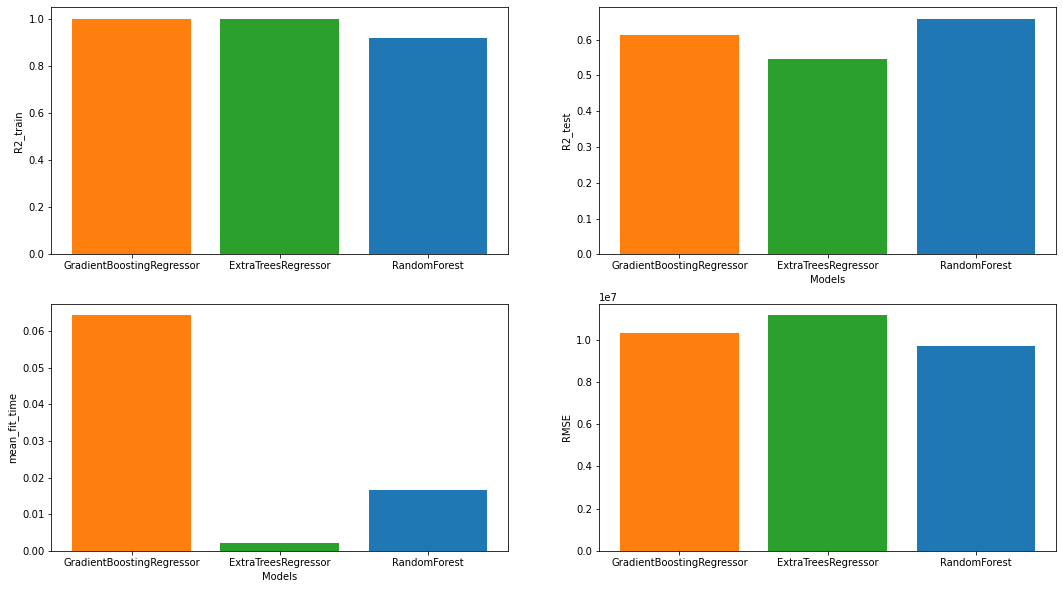

In [105]:

gradboost_params = {'gradientboostingregressor__n_estimators':[100, 500, 1000], 
                    'gradientboostingregressor__random_state': [0, 42]}

extr_params = {'extratreesregressor__n_estimators': [100, 500, 1000], 
              'extratreesregressor__random_state': [0, 42]}

rfr_params = {'randomforestregressor__n_estimators': [100, 500, 1000],
              'randomforestregressor__random_state': [0, 42]}        


mygrids = [gradboost_params, extr_params, rfr_params]

def data_score(models): 
    
    comparaison_score = pd.DataFrame()  
    
    for name_regressor, regressor, mygrid in zip(models.keys(), models.values(), mygrids):
    
        pipeline = make_pipeline(preprocessor_pipe, regressor)
        
        gridsc = GridSearchCV(pipeline,  param_grid = mygrid)
        
        model = gridsc.fit(X_train_r_p, y_train_r_p)
            
        best_model_index = model.best_index_
        
        comparaison_score.loc[name_regressor, 'R2_train'] =\
                                model.score(X_train_r_p, y_train_r_p)
        
        comparaison_score.loc[name_regressor, 'RMSE'] = \
                    math.sqrt(mean_squared_error(y_test_r_p, model.predict(X_test_r_p)))
        
        comparaison_score.loc[name_regressor, 'R2_test'] =\
                            r2_score(y_test_r_p, model.predict(X_test_r_p))
            
        comparaison_score.loc[name_regressor, 'mean_fit_time'] = \
                    model.cv_results_['std_fit_time'][best_model_index]
        
        print(model.best_params_)
    
    return comparaison_score
data_score = data_score(models = mymodels_2)
data_score  = data_score.reset_index()
data_score  = data_score.rename(columns = {'index': 'Models'})
display(data_score )
show_score(data_score , col1 = 'R2_train', col2 = 'R2_test', col3 = 'mean_fit_time', col4 ='RMSE')

### 4.3: Prédiction de l'énérgie 

In [180]:
def res_metrics(model, X_train, y_train, X_test, y_test):
    results = pd.DataFrame(
                columns = ['RMSE', 'R2_test',  'R2_train'])       
    results.loc['best_model', 'R2_train'] =\
                                model.score(X_train_r_p, y_train_r_p)
        
    results.loc['best_model', 'RMSE'] = \
                    math.sqrt(mean_squared_error(y_test_r_p, model.predict(X_test_r_p)))
        
    results.loc['best_model', 'R2_test'] =\
                            r2_score(y_test_r_p, model.predict(X_test_r_p))

    display(results)
    
    return results

In [239]:
X_train_r_p, X_test_r_p, y_train_r_p, y_test_r_p =  train_test_split(X_reduced_pipe, y,  
                                         test_size = 0.2, 
                                         random_state = 0) 

In [255]:
preprocessor_pipe_without_ESTSC = preprocessor(df_2016, preprocessor, target = ['SiteEnergyUseWN(kBtu)'], 
                            exclude = (['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'ENERGYSTARScore']))

In [310]:
from scipy import stats
def res_model(X_reduced):
 
    X_train_r_p, X_test_r_p, y_train_r_p, y_test_r_p =  train_test_split(X_reduced, y,  
                                         test_size = 0.2, 
                                         random_state = 0) 
    
    best_model = make_pipeline(preprocessor_pipe, RandomForestRegressor(n_estimators=100))
    best_model.fit(X_train_r_p, y_train_r_p)
    y_pred = best_model.predict(X_test_r_p)
#y_pred=y_pred.reshape(307,1)
    y_pred = pd.DataFrame(y_pred, columns =['SiteEnergyUseWN(kBtu)'])
    y_test_r_p = pd.DataFrame(y_test_r_p, columns =['SiteEnergyUseWN(kBtu)']).reset_index().drop('index', axis = 1)
    error = (y_pred['SiteEnergyUseWN(kBtu)'] - y_test_r_p['SiteEnergyUseWN(kBtu)'])

    
    res_metrics(model = best_model,  X_train = X_train_r_p, 
            y_train = y_train_r_p, X_test = X_test_r_p, 
            y_test = y_test_r_p)

#ata_score = data_score(models = best_model)
#data_score  = data_score.reset_index()
#data_score  = data_score.rename(columns = {'index': 'Models'})
#display(data_score )
#show_score(data_score , col1 = 'R2_train', col2 = 'R2_test', col3 = 'mean_fit_time', col4 ='RMSE')
    plt.figure(figsize=(20,13))
    plt.subplot(221)
    sns.scatterplot(x=y_test_r_p['SiteEnergyUseWN(kBtu)'], y=y_pred['SiteEnergyUseWN(kBtu)'], color='slateblue')
    plt.title("real vs prediction")
    plt.xlabel('real')
    plt.ylabel('prediction')
    x_max = max(y_test_r_p['SiteEnergyUseWN(kBtu)'].max(), y_pred['SiteEnergyUseWN(kBtu)'].max())
    x_min = min(y_test_r_p['SiteEnergyUseWN(kBtu)'].min(), y_pred['SiteEnergyUseWN(kBtu)'].min())
    plt.plot([x_min, x_max] ,[x_min, x_max])
#plt.ylim((0,4e8))
#plt.xlim((0,4e8))

#plt.ylim((0,1e7))

    plt.subplot(222)
    sns.distplot(error, kde=True, color='slateblue')
    plt.title("error distribution")
    plt.xlabel('')

#pipeline.named_steps['SiteEnergyUseWN(kBtu)'].feature_importances_
    importance_best_model = best_model.steps[1][1].feature_importances_
    feature_best_model = best_model.steps[0][1].get_feature_names_out()
    show_var_selec(var = feature_best_model, coeff = importance_best_model )


    plt.show




### 4.4: Resultats du Modéle en présence de La variable l’ENERGY STAR Score  

,RMSE,R2_test,R2_train
best_model,9318246.552778,0.684048,0.926773


Index(['Variable', 'Coefficient'], dtype='object')


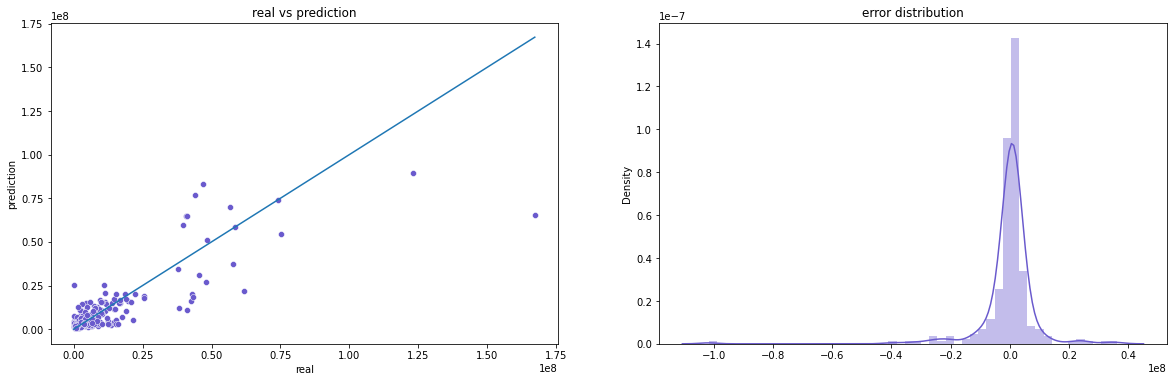

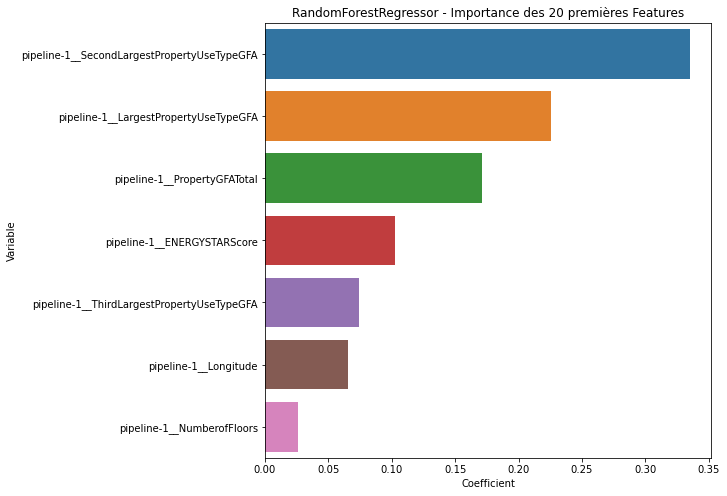

In [315]:
res_model(X_reduced = X_reduced_pipe)

### 4.5: Resultats du Modéle en présence de La variable l’ENERGY STAR Score  

,RMSE,R2_test,R2_train
best_model,10051494.956535,0.632368,0.903127


Index(['Variable', 'Coefficient'], dtype='object')


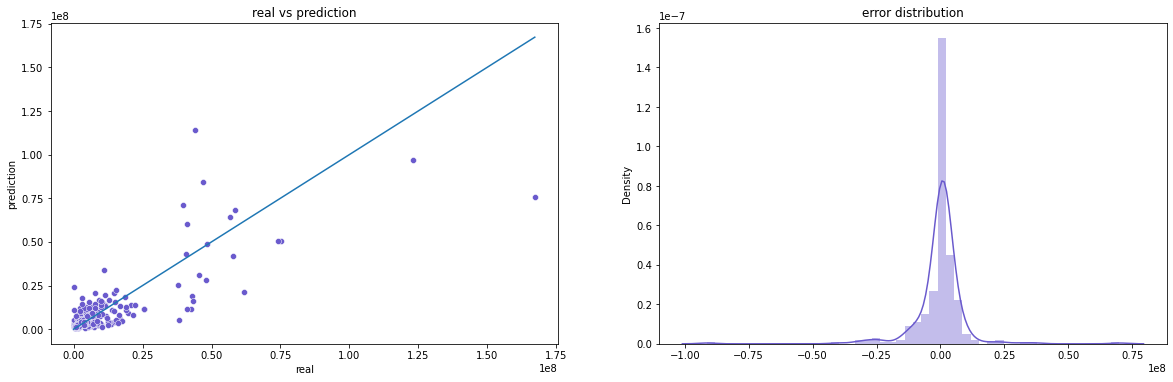

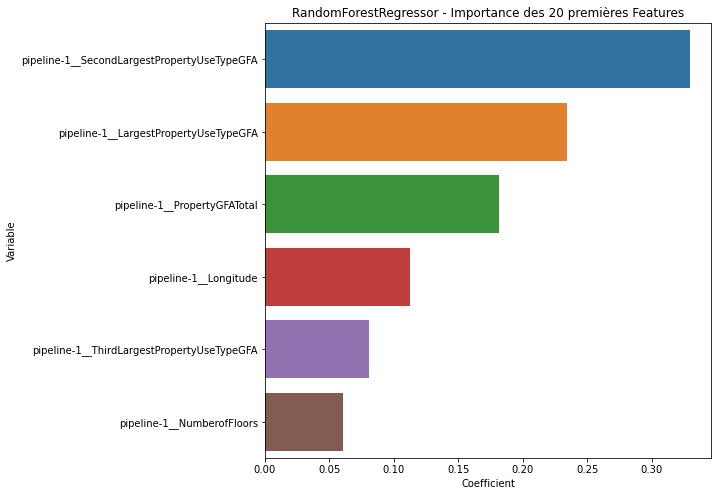

In [320]:
res_model(X_reduced = X_reduced_pipe.drop('ENERGYSTARScore', axis = 1))

In [ ]:
X_train_r_p, X_test_r_p, y_train_r_p, y_test_r_p =  train_test_split, y,  
                                         test_size = 0.2, 
                                         random_state = 0) 

## 5:  Export des modèles pour réutilisation ultérieure

In [207]:
import pickle
with open('model_pickle', 'wb') as f:
    pickle.dump(best_model, f)

In [208]:
import pickle
with open('model_pickle', 'rb') as f:
    app_model = pickle.load(f)

### 5.1:  Prédiction de l'énérgie d'une nouveau Datataset

In [209]:
X_data = data.select_dtypes(['int64','float64'])
y_data = data['SiteEnergyUseWN(kBtu)']
X_data = X_data.drop(['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'], axis = 1)

In [210]:
y_pred_data = app_model.predict((X_data))
y_pred_data = pd.DataFrame(y_pred_data, columns =['SiteEnergyUseWN(kBtu)'])
r2_score(y_data, app_model.predict(X_data))
error = y_pred_data['SiteEnergyUseWN(kBtu)'] - y_data 

0.4307815632027916
Index(['Variable', 'Coefficient'], dtype='object')


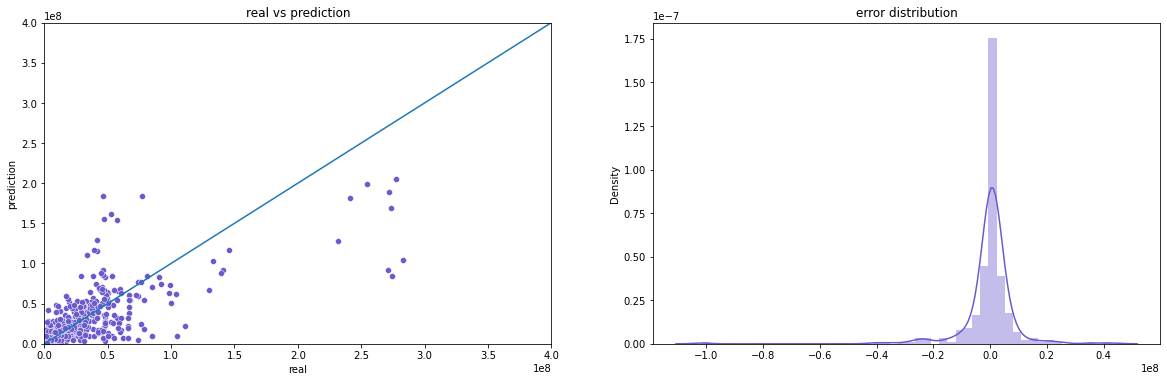

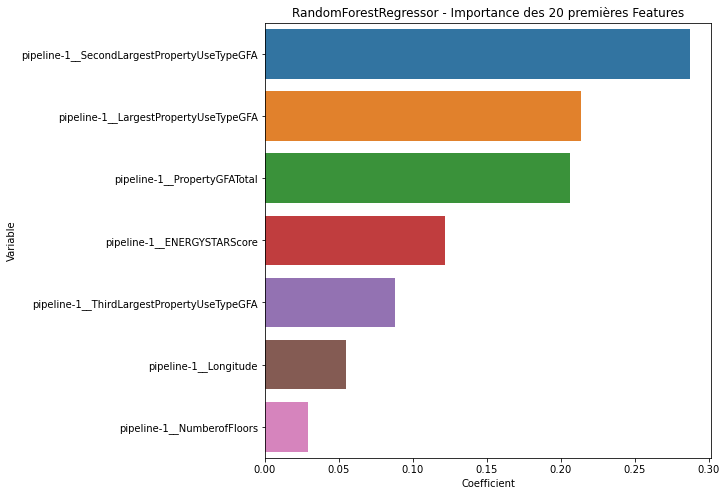

In [319]:
#y_pred = pd.DataFrame(y_pred, columns =['SiteEnergyUseWN(kBtu)'])
print(r2_score(y_data, app_model.predict(X_data)))
#res_metrics(model = app_model)
#error = abs((y_pred1 - y_data))

plt.figure(figsize=(20,13))

plt.subplot(221)
sns.scatterplot(x=y_data, y=y_pred_data['SiteEnergyUseWN(kBtu)'], color='slateblue')
sns.lineplot(color='red')
plt.title("real vs prediction")
plt.xlabel('real')
plt.ylabel('prediction')
x_max = max(y_data.max(), y_pred_data['SiteEnergyUseWN(kBtu)'].max())
x_min = min(y_data.min(), y_pred_data['SiteEnergyUseWN(kBtu)'].min())
plt.plot([x_min, x_max] ,[x_min, x_max])
plt.ylim((0,4e8))
plt.xlim((0,4e8))

plt.subplot(222)
sns.distplot(error, kde=True, color='slateblue')
plt.title("error distribution")
plt.xlabel('')

importance_app_model = app_model.steps[1][1].feature_importances_
feature_app_model = app_model.steps[0][1].get_feature_names_out()
show_var_selec(var = feature_app_model, coeff = importance_app_model )
plt.show()